In [1]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, sum, udf, when, size, row_number, array, struct, monotonically_increasing_id
from pyspark.sql import functions as F
from pyspark.ml.linalg import Vectors
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession 
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import ArrayType, DoubleType, IntegerType, StringType, FloatType, TimestampType

from sklearn.decomposition import PCA as SklearnPCA
import numpy as np


spark = (SparkSession.
     builder.
     master('local[*]'). # leave out for cluster mode
     appName('single-elders-monitoring').
     config(conf = SparkConf()).
     getOrCreate())



def my_f(features_matrix):
    event = -1
    
    pca_input = np.array([v.toArray() for v in features_matrix])
    
    if (pca_input.shape[0] == 361):
        pca = SklearnPCA(n_components=2)

        pca.fit(pca_input[:-1, :])
        
        transformed_features = pca.transform(pca_input[:-1, :])
        last_element_pca = pca.transform([pca_input[-1, :]])
        
        means = np.mean(transformed_features, axis=0)
        cov_matrix_sample = np.cov(transformed_features.T)   
        inv_cov_matrix_sample = np.linalg.inv(cov_matrix_sample)

        tmp = last_element_pca - means

        mahalanobis_tsquare_ratio =  (tmp @ inv_cov_matrix_sample @ tmp.T).item()**(-1/2)
        
        event = 1 if mahalanobis_tsquare_ratio > 1 else 0 
    
    return event
    



inv_transf_occupants = spark.read.csv("./data/database_gas_after_environmental_correction.csv", header=True, inferSchema=True)
columns_to_transform = inv_transf_occupants.columns
columns_to_transform.remove("timestamp")


    
assembler = VectorAssembler(inputCols=columns_to_transform, outputCol='featuresToWindowPCA')
assembled_features = assembler.transform(inv_transf_occupants)

window_size = 360
window_spec = Window.rowsBetween(-window_size, 0).orderBy("timestamp") ## ADD patitioning

my_f_udf = F.udf(my_f, IntegerType())

inv_transf_occupants = assembled_features.withColumn("event", 
                                                     my_f_udf(F.collect_list("featuresToWindowPCA").over(window_spec))).where("timestamp >= '2019-11-30' AND timestamp <= '2020-01-01'")

inv_transf_occupants_pd = inv_transf_occupants.orderBy("timestamp").toPandas()
inv_transf_occupants_pd.iloc[:10,:]

24/05/19 13:29:53 WARN Utils: Your hostname, spark-master resolves to a loopback address: 127.0.2.1; using 10.0.2.15 instead (on interface eth0)
24/05/19 13:29:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/19 13:29:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/19 13:29:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/19 13:29:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/19 13:30:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue,featuresToWindowPCA,event
0,2019-11-30 00:00:14.036811,21.225081,50.878358,120.695730,584.968351,459.231455,718.260244,659.579219,595.914935,102.517375,"[21.225081057918008, 50.87835846454281, 120.69...",0
1,2019-11-30 00:00:33.902891,21.219651,50.894031,120.248978,584.875896,459.091697,718.166663,659.468979,595.791828,102.121457,"[21.219651498387094, 50.89403149252188, 120.24...",0
2,2019-11-30 00:00:53.902508,21.159984,50.906484,119.811110,584.768017,458.928623,718.057470,659.340346,595.648181,102.242904,"[21.159984171600254, 50.906483886158234, 119.8...",0
3,2019-11-30 00:01:13.976992,21.100319,50.918936,119.373241,584.660140,458.765552,717.948279,659.211717,595.504538,102.364347,"[21.100318637753578, 50.918936012664645, 119.3...",0
4,2019-11-30 00:01:34.033239,21.099806,50.927737,119.367265,584.670516,458.781237,717.958782,659.224089,595.518354,102.352667,"[21.0998056882248, 50.927736659117244, 119.367...",0
5,2019-11-30 00:01:54.139075,21.099293,50.936537,119.361289,584.680891,458.796921,717.969284,659.236461,595.532170,102.340986,"[21.09929273869603, 50.93653730556985, 119.361...",0
6,2019-11-30 00:02:13.997897,21.085191,50.938638,119.371772,584.662690,458.769407,717.950861,659.214758,595.507934,102.361476,"[21.085191264339855, 50.93863828255395, 119.37...",0
7,2019-11-30 00:02:34.037808,21.072526,50.944088,118.898963,584.615478,458.698040,717.903074,659.158464,595.445070,102.414625,"[21.072525863839996, 50.944087864793204, 118.8...",0
8,2019-11-30 00:02:54.081822,21.075880,50.956921,118.438043,584.547623,459.095468,717.834392,659.077555,595.354717,102.491014,"[21.075880423409146, 50.95692142358633, 118.43...",0
9,2019-11-30 00:03:14.161758,21.077801,50.966406,118.460414,584.508780,459.536751,717.795076,659.031239,595.302996,102.534742,"[21.077800702062138, 50.96640610999436, 118.46...",0


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 59024)
Traceback (most recent call last):
  File "/usr/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/home/vagrant/.local/lib/python3.10/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/home/vagrant/.local/lib/python3.10/site-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
  File "/home/vagrant/.local/lib/python3.10/site-packages/pyspark/accumulators.py", line 271, in accum_updat

In [2]:
inv_transf_occupants_pd.to_csv("./data/database_gas_after_environmental_correction_with_event.csv", sep=',', index=False)
inv_transf_occupants_pd


,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue,featuresToWindowPCA,event
0,2019-11-30 00:00:14.036811,21.225081,50.878358,120.695730,584.968351,459.231455,718.260244,659.579219,595.914935,102.517375,"[21.225081057918008, 50.87835846454281, 120.69...",0
1,2019-11-30 00:00:33.902891,21.219651,50.894031,120.248978,584.875896,459.091697,718.166663,659.468979,595.791828,102.121457,"[21.219651498387094, 50.89403149252188, 120.24...",0
2,2019-11-30 00:00:53.902508,21.159984,50.906484,119.811110,584.768017,458.928623,718.057470,659.340346,595.648181,102.242904,"[21.159984171600254, 50.906483886158234, 119.8...",0
3,2019-11-30 00:01:13.976992,21.100319,50.918936,119.373241,584.660140,458.765552,717.948279,659.211717,595.504538,102.364347,"[21.100318637753578, 50.918936012664645, 119.3...",0
4,2019-11-30 00:01:34.033239,21.099806,50.927737,119.367265,584.670516,458.781237,717.958782,659.224089,595.518354,102.352667,"[21.0998056882248, 50.927736659117244, 119.367...",0
...,...,...,...,...,...,...,...,...,...,...,...,...
135406,2019-12-31 23:58:27.272336,19.140469,39.049722,255.425608,586.175305,503.986924,704.456158,668.408216,601.045641,197.597788,"[19.140468662678902, 39.049721763348444, 255.4...",0
135407,2019-12-31 23:58:46.985107,19.038402,39.111597,255.634545,585.812528,504.938537,704.088964,667.975651,601.062587,197.506187,"[19.038402348122993, 39.111597166079775, 255.6...",0
135408,2019-12-31 23:59:07.079790,18.936338,39.173472,255.843480,585.449753,505.890154,703.721771,667.543088,601.079537,197.414585,"[18.93633782650725, 39.17347230168116, 255.843...",0
135409,2019-12-31 23:59:27.286586,18.939131,39.179994,255.876020,585.393255,505.804748,703.664584,667.475721,601.004306,196.978189,"[18.939130943935744, 39.17999389289753, 255.87...",0


In [3]:
inv_transf_occupants = spark.read.csv("./data/database_gas_after_environmental_correction_with_event.csv", header=True, inferSchema=True)
inv_transf_occupants.toPandas().iloc[:10, :]


,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue,featuresToWindowPCA,event
0,2019-11-30 00:00:14.036811,21.225081,50.878358,120.695730,584.968351,459.231455,718.260244,659.579219,595.914935,102.517375,"[21.225081057918008,50.87835846454281,120.6957...",0
1,2019-11-30 00:00:33.902891,21.219651,50.894031,120.248978,584.875896,459.091697,718.166663,659.468979,595.791828,102.121457,"[21.219651498387094,50.89403149252188,120.2489...",0
2,2019-11-30 00:00:53.902508,21.159984,50.906484,119.811110,584.768017,458.928623,718.057470,659.340346,595.648181,102.242904,"[21.159984171600254,50.906483886158234,119.811...",0
3,2019-11-30 00:01:13.976992,21.100319,50.918936,119.373241,584.660140,458.765552,717.948279,659.211717,595.504538,102.364347,"[21.100318637753578,50.918936012664645,119.373...",0
4,2019-11-30 00:01:34.033239,21.099806,50.927737,119.367265,584.670516,458.781237,717.958782,659.224089,595.518354,102.352667,"[21.0998056882248,50.927736659117244,119.36726...",0
5,2019-11-30 00:01:54.139075,21.099293,50.936537,119.361289,584.680891,458.796921,717.969284,659.236461,595.532170,102.340986,"[21.09929273869603,50.93653730556985,119.36128...",0
6,2019-11-30 00:02:13.997897,21.085191,50.938638,119.371772,584.662690,458.769407,717.950861,659.214758,595.507934,102.361476,"[21.085191264339855,50.93863828255395,119.3717...",0
7,2019-11-30 00:02:34.037808,21.072526,50.944088,118.898963,584.615478,458.698040,717.903074,659.158464,595.445070,102.414625,"[21.072525863839996,50.944087864793204,118.898...",0
8,2019-11-30 00:02:54.081822,21.075880,50.956921,118.438043,584.547623,459.095468,717.834392,659.077555,595.354717,102.491014,"[21.075880423409146,50.95692142358633,118.4380...",0
9,2019-11-30 00:03:14.161758,21.077801,50.966406,118.460414,584.508780,459.536751,717.795076,659.031239,595.302996,102.534742,"[21.077800702062138,50.96640610999436,118.4604...",0


In [4]:
from pyspark.sql.functions import hour
from pyspark.sql.functions import date_format, sum, when



inv_transf_occupants = inv_transf_occupants.withColumn("date_hour", date_format(inv_transf_occupants["timestamp"], "yyyy-MM-dd HH"))

inv_transf_occupants = inv_transf_occupants.groupBy("date_hour").agg(
    sum(when(inv_transf_occupants["event"] == 1, 1).otherwise(0)).alias("n_event")
)

inv_transf_occupants = inv_transf_occupants.orderBy("date_hour").toPandas()
inv_transf_occupants

,date_hour,n_event
0,2019-11-30 00,0
1,2019-11-30 01,0
2,2019-11-30 02,0
3,2019-11-30 03,0
4,2019-11-30 04,0
...,...,...
750,2019-12-31 19,41
751,2019-12-31 20,102
752,2019-12-31 21,0
753,2019-12-31 22,0


<BarContainer object of 100 artists>

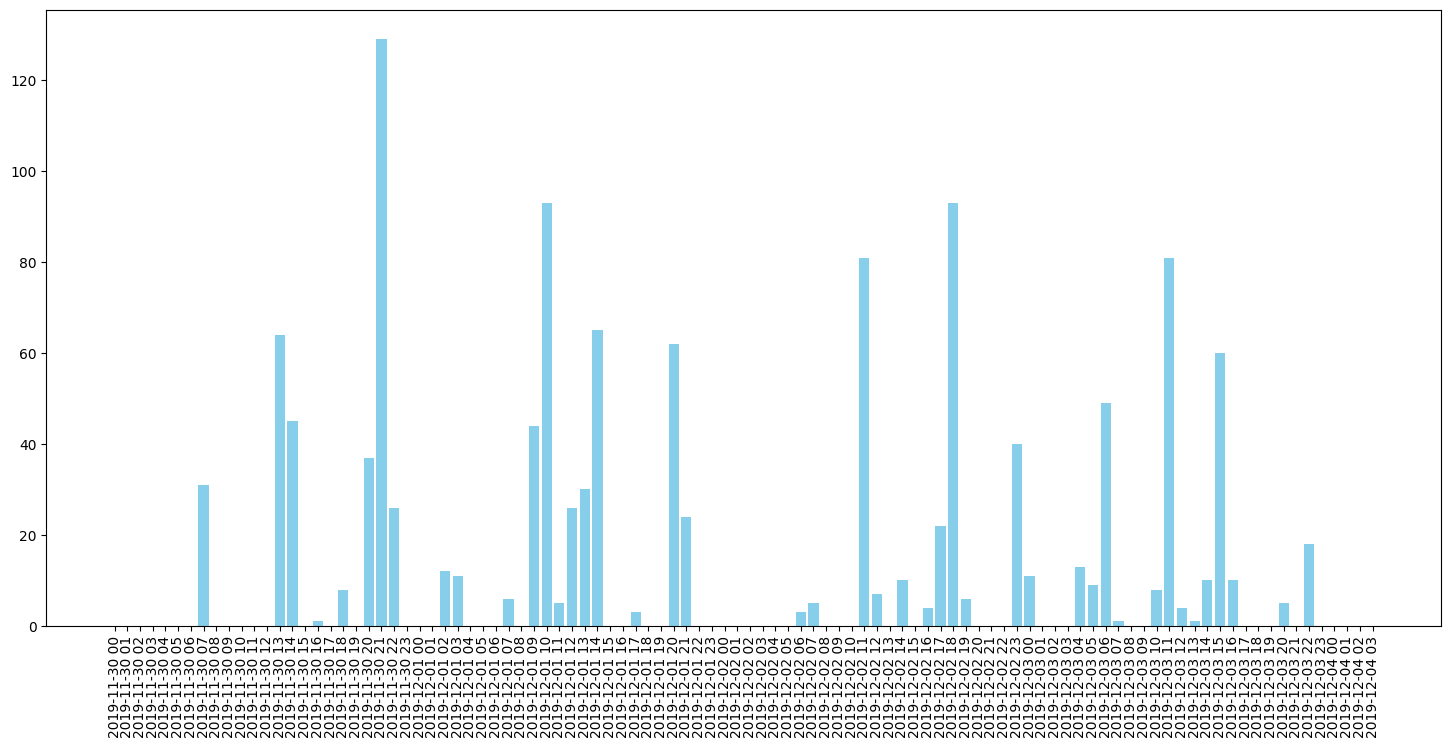

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 8))  # Impostare la dimensione della figura

plt.xticks(rotation=90)
plt.bar(inv_transf_occupants.iloc[:100]['date_hour'], inv_transf_occupants.iloc[:100]['n_event'], color='skyblue')


In [6]:
inv_transf_occupants = inv_transf_occupants.withColumn("date", date_format(inv_transf_occupants["date_hour"], "yyyy-MM-dd"))
inv_transf_occupants = inv_transf_occupants.withColumn("hour", hour(inv_transf_occupants["date_hour"], "HH"))


pivot_df = df.pivot(index='date', columns='hour', values='n_event')

# Crea la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, cmap='viridis', annot=True, fmt=".1f")

AttributeError: 'DataFrame' object has no attribute 'withColumn'